In [1]:
import numpy as np
import scipy as sp
import tfc as tfc
from tfc import utfc
from matplotlib import pyplot as plt
import jax.numpy as np
from jax import jit
from tfc.utils import egrad

UTFC has 3 positional arguments

1. N number of discretization points
2. $n_c$ are basis functions removed
3. m degree of basis function expansion

Some functions in the basis function expansion are linearly dependent to the support functions.  For example if the basis functions are polynomials and the support functions are monomials, then one needs to remove the first $n_c$ basis functions where $n_c$ is the number of constraints



In [2]:
myTFC = utfc(100,2,5,x0=0,xf=1)
print("Number of basis functions: "+str(myTFC.basisClass.m-myTFC.basisClass.numC))



x0 is an integer. Converting to float to avoid errors down the line.
xf is an integer. Converting to float to avoid errors down the line.
Number of basis functions: 4


In [3]:
print(myTFC.nC) # returns list of first nc terms removed

[0 1]


In [4]:
# alternative way to represent removed elements

myTFC = utfc(100,[0,2],5,x0=0,xf=1)
print("Number of basis functions: "+str(myTFC.basisClass.m-myTFC.basisClass.numC))
print("Basis functions removed: "+str(myTFC.nC))

x0 is an integer. Converting to float to avoid errors down the line.
xf is an integer. Converting to float to avoid errors down the line.
Number of basis functions: 4
Basis functions removed: [0 2]


In [5]:
#If one wanted to keep all basis functions, this could accomplished by setting nC = -1

myTFC = utfc(100,-1,5,x0=0,xf=1)
print("Number of basis functions: "+str(myTFC.basisClass.m-myTFC.basisClass.numC))
print("Basis functions removed: "+str(myTFC.nC))

x0 is an integer. Converting to float to avoid errors down the line.
xf is an integer. Converting to float to avoid errors down the line.
Number of basis functions: 6
Basis functions removed: []


In [6]:
# can choose polynomial basis used
# Chebyshev is default, but have options for Legendre, Fourier, ELMRelu -sigmoid, -tanh etc
myTFC = utfc(100,-1,5,x0=3,xf=7)



x0 is an integer. Converting to float to avoid errors down the line.
xf is an integer. Converting to float to avoid errors down the line.


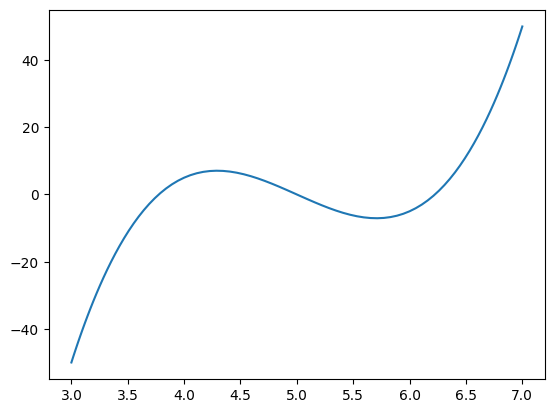

In [7]:
x = myTFC.x # possesses x coordinate
H = myTFC.H # possesses all the polynomial values at the collocation points num grid points x number of polynomials used
d2H = myTFC.d2H # can take derivatives dH, d2H, d4H, d6H, d8H higher order derivatives require different module
plt.plot(x,d2H(x)[:,5])

In [8]:
import jax.numpy as np
from jax import jit
from tfc.utils import egrad
dH = myTFC.dH
dHjax = jit(egrad(H))
assert(np.all(dH(x)==dHjax(x)))


## Solving ODEs

Want to solve the following ODE:

$$
y_{xx} +y_xy = e^{-2x}\sin(x)(\cos(x)-\sin(x))-2e^{-x}\cos({x})
$$

with bc

$$
y(0) =0\quad y(\pi) = 0
$$

on domain $x \in [0,\pi]$.

Solution is

$$
y(x) = e^{-x}\sin(x)
$$



In [9]:
import jax.numpy as np
from tfc import utfc

# Create the univariate TFC class
N = 100 # Number of points in the domain
m = 30 # Degree of basis function expansion
nC = 2 # Indicates which basis functions need to be removed from the expansion

myTfc = utfc(N,nC,m,x0=0,xf=np.pi)

# Create the analytical solution
realSoln = lambda x: np.exp(-x)*np.sin(x)



x0 is an integer. Converting to float to avoid errors down the line.


Develop the constrained expression

$$
y(x,g(x)) = g(x) - \frac{\pi-x}{\pi}g(0) - \frac{x}{\pi}g(\pi)
$$



In [10]:
x = myTfc.x # Collocation points from the TFC class

# Get the basis functions from the TFC class
H = myTfc.H

# Create the constrained expression
g = lambda x,xi: np.dot(H(x),xi)
y = lambda x,xi: g(x,xi) - (np.pi-x)/np.pi*g(np.zeros_like(x),xi) - x/np.pi*g(np.pi*np.ones_like(x),xi)

In [11]:
from tfc.utils import egrad, NLLS

# Create the residual
dy = egrad(y)
d2y = egrad(dy)
L = lambda xi: d2y(x,xi)+dy(x,xi)*y(x,xi)-np.exp(-2.*x)*np.sin(x)*(np.cos(x)-np.sin(x))+2.*np.exp(-x)*np.cos(x)

# Minimize the residual using least-squares
xi0 = np.zeros(H(x).shape[1])
xi,_,time = NLLS(xi0,L,timer=True)

Maximum error on test set: 1.1102230246251565e-16
Mean error on the test set: 3.3555318405894e-17
TFC run time: 0.0 seconds


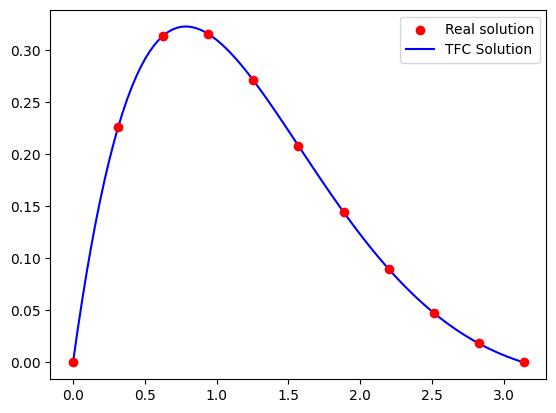

In [12]:
# Calculate the error on the test set
testSet = np.linspace(0,np.pi,101)
error = np.abs(y(testSet,xi)-realSoln(testSet))

# Print out the results
print("Maximum error on test set: " +str(np.max(error)))
print("Mean error on the test set: "+str(np.mean(error)))
print("TFC run time: "+str(time)+" seconds")

# Plot the results
from tfc.utils import MakePlot

# This line is added for Python notebooks but is not necessary in a regular Python script.
#%matplotlib inline

#p = MakePlot(r'$x$','$y$')
#p.ax[0].scatter(testSet[::10],realSoln(testSet)[::10],color='r',label='Real solution',zorder=3)
#p.ax[0].plot(testSet,y(testSet,xi),'b-',label='TFC Solution')
#p.ax[0].legend()
#p.show()

plt.scatter(testSet[::10],realSoln(testSet)[::10],color='r',label='Real solution',zorder=3)
plt.plot(testSet,y(testSet,xi),'b-',label='TFC Solution')
plt.legend()
plt.show()



### System of ODEs problem

Consider the system:

$$
\ddot{y} = -4z
$$

$$
\ddot{z} = 8z +4y
$$

subject to the following boundary conditions
$$
y(0)=-1,\quad y(3) = -e^6,\quad z(0)=1,\quad z(3)=e^6
$$

over time domain $t \in [0,3]$

Analytic Solutions are

$$
y(t) = -e^{2t}\quad z(t) = e^{2t}
$$

In [132]:
import jax.numpy as np
from tfc import utfc

# Create the univariate TFC class
N = 100 # Number of points in the domain
m = 100 # Degree of basis function expansion
nC = 2 # Indicates which basis functions need to be removed from the expansion

myTfc = utfc(N,nC,m,x0=0,xf=3,basis="ELMTanh")

# Create the analytical solutions
yReal = np.vectorize(lambda t: -np.exp(2.0*t))
zReal = np.vectorize(lambda t: np.exp(2.0*t))

x0 is an integer. Converting to float to avoid errors down the line.
xf is an integer. Converting to float to avoid errors down the line.


Generate constrained expressions for y and z

$$
y(t,g^y(t)) = g^y(t) + \frac{3-t}{3}(-1-g^y(0))+\frac{t}{3}(-e^{-6}-g^y(3))
$$

$$
z(t,g^z(t)) = g^z(t)+\frac{3-t}{3}(1-g^z(0)) +\frac{t}{3}(e^6-g^z(3))
$$


In [133]:

t = myTfc.x # Collocation points from the TFC class

# Get the basis functions from the TFC class
H = myTfc.H

# Create the constrained expressions
g = lambda t,xi: np.dot(H(t),xi)
y = lambda t,xi_y: g(t,xi_y) + ((3.0-t)/3.0) * (-1.0 - g(np.zeros_like(t),xi_y)) + t/3.0 * (-np.exp(6.0)-g(3.0*np.ones_like(t),xi_y))
z = lambda t,xi_z: g(t,xi_z) + ((3.0-t)/3.0) * (1.0 - g(np.zeros_like(t),xi_z)) + t/3.0 * (np.exp(6.0)-g(3.0*np.ones_like(t),xi_z))




In [134]:
from tfc.utils import egrad, LS, TFCDict

# Create a TFCDict of the unknowns
xi0 = TFCDict({
    "xi_y": np.zeros(H(t).shape[1]),
    "xi_z": np.zeros(H(t).shape[1])
})

# Create the individual residuals
d2z = egrad(egrad(z))
d2y = egrad(egrad(y))

Ly = lambda t,xi: -d2y(t,xi["xi_y"]) - 4.0 * z(t,xi["xi_z"])
Lz = lambda t,xi: -d2z(t,xi["xi_z"]) + 8.0 * z(t,xi["xi_z"]) + 4.0 * y(t,xi["xi_y"])

# Combine the residuals into one function
L = lambda xi: np.hstack([Ly(t,xi), Lz(t,xi)])

# Minimize the residual using least-squares
xi,time = LS(xi0,L,timer=True)

Run time: 0.09375
Maximum error on y: 9.273499596673673e-05
Maximum error on z: 3.91665126713292e-05


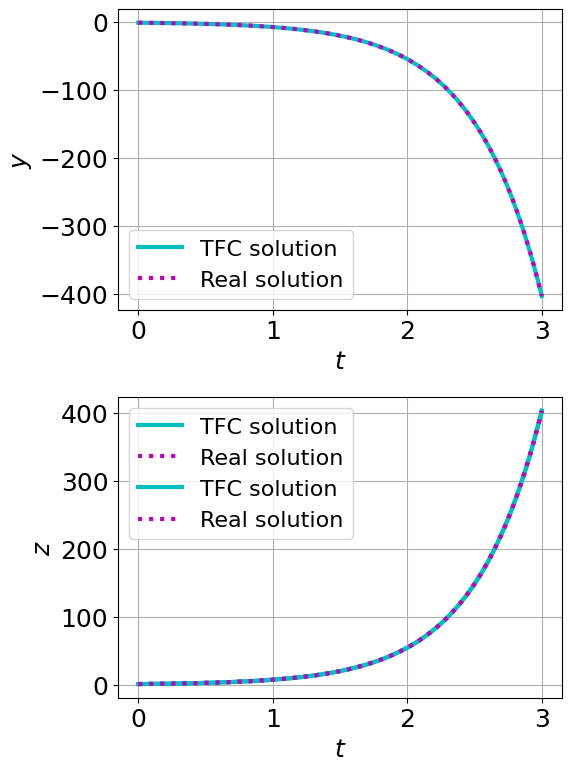

In [135]:
# Calculate the error on the test set
t_test = np.linspace(0.0, 3.0, 100)
errY = y(t_test,xi["xi_y"]) - yReal(t_test)
errZ = z(t_test,xi["xi_z"]) - zReal(t_test)

# Print out the results
print(f"Run time: {time}")
print(f"Maximum error on y: {np.max(np.abs(errY))}")
print(f"Maximum error on z: {np.max(np.abs(errZ))}")

# Plot the results
from tfc.utils import MakePlot

# This line is added for Python notebooks but is not necessary in a regular Python script.
%matplotlib inline
import matplotlib
matplotlib

plt.close('all')
p = MakePlot([r"$t$",r"$t$"],[r"$y$",r"$z$"])
p.ax[0].plot(t_test,y(t_test,xi["xi_y"]),label="TFC solution",color="c",linewidth=3)
p.ax[0].plot(t_test,yReal(t_test),label="Real solution",color="m",linestyle=":",linewidth=3)
#plt.plot(t_test,y(t_test,xi["xi_y"]),label="TFC solution",color="c",linewidth=3)
#plt.plot(t_test,yReal(t_test),label="Real solution",color="m",linestyle=":",linewidth=3)
#plt.show()
p.ax[1].plot(t_test,z(t_test,xi["xi_z"]),label="TFC solution",color="c",linewidth=3)
p.ax[1].plot(t_test,zReal(t_test),label="Real solution",color="m",linestyle=":",linewidth=3)
plt.plot(t_test,z(t_test,xi["xi_z"]),label="TFC solution",color="c",linewidth=3)
plt.plot(t_test,zReal(t_test),label="Real solution",color="m",linestyle=":",linewidth=3)
for ax in p.ax:
    ax.legend()
    ax.grid()
p.PartScreen(6,8)
p.fig.tight_layout(w_pad=None)
plt.show()

### Applying this code to an optimal control problem

Our problem has the following dynamics

$$
\dot{x} = -x+u \quad 0 \leq t \leq 1 \quad x(0)=1
$$

with reward functional

$$
\min J(x,u) = \frac{1}{2}\int_0^1 x^2 + u^2 dt.
$$

We have the following Hamiltonian:

$$
H(t) = \frac{1}{2} (x^2 +u^2) + p(-x+u)
$$

Control optimality comes from
$$
\frac{\partial H}{\partial u} = 0 \Rightarrow u = -p
$$
so
$$
H(t) = -\frac{1}{2}p^2 -px + \frac{1}{2}x^2
$$
First order necessary conditions require
$$
\dot{x} = \frac{\partial H}{\partial p} = -x-p
$$
$$
\dot{p} = -\frac{\partial H}{\partial x} = p-x
$$
subject to $x(0)=x_0=1, p(1) = p_f =0$.



We can determine an analytic solution to this problem by recognizing that this is a linear differential system which can be rewritten as 
$$
\begin{bmatrix}\dot{x}\\\dot{p} \end{bmatrix} = \begin{bmatrix}-1&-1\\-1&1\end{bmatrix}\begin{bmatrix}x\\ p\end{bmatrix}
$$

with the same boundary conditions.  We know that the solution will have the following form:

$$
\begin{bmatrix}x(t)\\ p(t) \end{bmatrix} = c_1 e^{\sqrt{2}t}\begin{bmatrix}1-\sqrt{2}\\ 1\end{bmatrix} +c_2 e^{-\sqrt{2}t}\begin{bmatrix}1+\sqrt{2}\\1 \end{bmatrix}
$$

This will yield the following system of 4 equations:

\begin{equation}
\begin{split}
1 &= c_1(1-\sqrt{2})+c_2(1+\sqrt{2}) \\
p(0) &= c_1 +c_2\\
x(1) &= c_1e^{\sqrt{2}}(1-\sqrt{2}) +c_2 e^{-\sqrt{2}}(1+\sqrt{2})\\
0 &= c_1 e^{\sqrt{2}} + c_2 e^{-\sqrt{2}}
\end{split}
\end{equation}

Because this is a system of 4 equations with 4 unknowns, it can be solved uniquely.

In [204]:
optmat = np.array([[1-np.sqrt(2), 1+np.sqrt(2), 0,  0],[1, 1, 0, -1],\
           [np.exp(np.sqrt(2))*(1-np.sqrt(2)),np.exp(-np.sqrt(2))*(1+np.sqrt(2)), -1, 0],\
            [np.exp(np.sqrt(2)), np.exp(-np.sqrt(2)),0,0]])
optvec = np.array([1,0,0,0])
print(optmat)
solvec = np.linalg.solve(optmat,optvec)
#solvec = np.matmul(np.linalg.pinv(optmat),optvec)
print(solvec)
#np.linalg.pinv(optmat)

optmat2 = np.array([[1-np.sqrt(2), 1+np.sqrt(2)],\
            [np.exp(np.sqrt(2)), np.exp(-np.sqrt(2))]])

optvec2 = np.array([1,0])

#solvevec2 = np.linalg.solve(optmat2,optvec2)
#solvevec2

[[-0.41421356  2.41421356  0.          0.        ]
 [ 1.          1.          0.         -1.        ]
 [-1.70376409  0.58693572 -1.          0.        ]
 [ 4.11325038  0.24311673  0.          0.        ]]
[-0.02423662  0.41005522  0.28196953  0.3858186 ]


Ergo our optimal solution is

\begin{equation}
\begin{bmatrix}x(t)\\
p(t) \end{bmatrix} = -0.02423662e^{\sqrt{2}t}\begin{bmatrix}1-\sqrt{2}\\1 \end{bmatrix} + 0.41005522 e^{-\sqrt{2}t}\begin{bmatrix}1+\sqrt{2}\\1\end{bmatrix} 
\end{equation}

In [137]:
-0.02423662*np.exp(np.sqrt(2))+0.41005522*np.exp(-np.sqrt(2))


Array(-3.71314604e-10, dtype=float64, weak_type=True)

In [291]:
import jax.numpy as np
from tfc import utfc

# Create the univariate TFC class
N = 100 # Number of points in the domain
m = 30 #  Degree of basis function expansion 
nC = 1
 # Indicates which basis functions need to be removed from the expansion

myTfc = utfc(N,nC,m,x0=0,xf=1,basis="ELMTanh")
freal = np.vectorize(lambda t: -0.02423662*np.exp(np.sqrt(2)*t)*(1-np.sqrt(2))+0.41005522*np.exp(-np.sqrt(2)*t)*(1+np.sqrt(2)))
preal = np.vectorize(lambda t: -0.02423662*np.exp(np.sqrt(2)*t)+0.41005522*np.exp(-np.sqrt(2)*t))

x0 is an integer. Converting to float to avoid errors down the line.
xf is an integer. Converting to float to avoid errors down the line.


In [292]:
t = myTfc.x # Collocation points from the TFC class

# Get the basis functions from the TFC class
H = myTfc.H

# Create the constrained expressions
g = lambda t,xi: np.dot(H(t),xi)
f = lambda t,xi_f: g(t,xi_f) + (1-t)* (1.0 - g(np.zeros_like(t),xi_f)) 
p = lambda t,xi_p: g(t,xi_p) + (0+t) * ( 0- g(np.ones_like(t),xi_p))




In [293]:
from tfc.utils import egrad, LS, TFCDict

# Create a TFCDict of the unknowns
xi0 = TFCDict({
    "xi_f": np.zeros(H(t).shape[1]),
    "xi_p": np.zeros(H(t).shape[1])
})

# Create the individual residuals
df = egrad(f)
dp = egrad(p)

Lf = lambda t,xi: df(t,xi["xi_f"]) + f(t,xi["xi_f"]) + p(t,xi["xi_p"])
Lp = lambda t,xi: dp(t,xi["xi_p"]) - p(t,xi["xi_p"]) + f(t,xi["xi_f"])

# Combine the residuals into one function
L = lambda xi: np.hstack([Lf(t,xi), Lp(t,xi)])

# Minimize the residual using least-squares
xi,time = LS(xi0,L,timer=True)

Run time: 0.0
Maximum error on f: 2.3908116958404335e-07
Maximum error on p: 6.404757831868224e-07


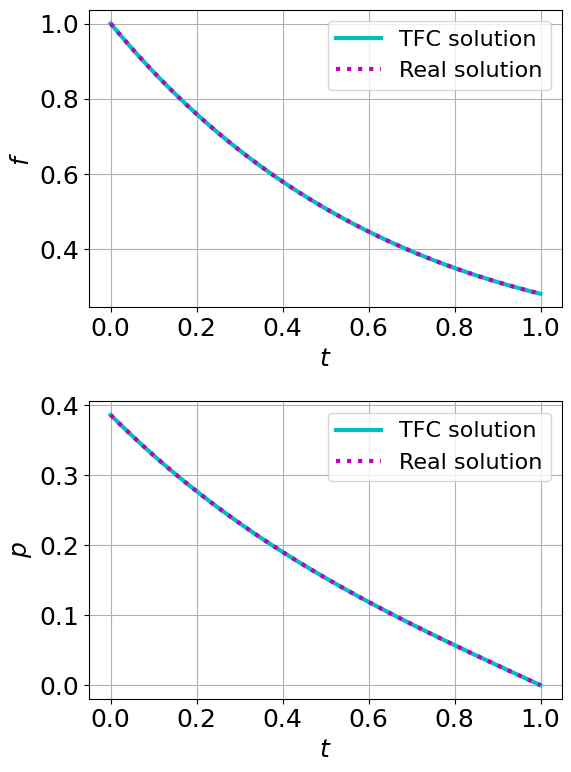

In [294]:
# Calculate the error on the test set
t_test = np.linspace(0.0, 1.0, 500)
errf = np.abs(f(t_test,xi["xi_f"]) - freal(t_test))
errp = np.abs(p(t_test,xi["xi_p"]) - preal(t_test))

# Print out the results
print(f"Run time: {time}")
print(f"Maximum error on f: {np.max(np.abs(errf))}")
print(f"Maximum error on p: {np.max(np.abs(errp))}")


# Plot the results
from tfc.utils import MakePlot

# This line is added for Python notebooks but is not necessary in a regular Python script.
%matplotlib inline
import matplotlib
matplotlib

plt.close('all')
i = MakePlot([r"$t$",r"$t$"],[r"$f$",r"$p$"])
i.ax[0].plot(t_test,f(t_test,xi["xi_f"]),label="TFC solution",color="c",linewidth=3)
i.ax[0].plot(t_test,freal(t_test),label="Real solution",color="m",linestyle=":",linewidth=3)
#plt.plot(t_test,f(t_test,xi["xi_f"]),label="TFC solution",color="c",linewidth=3)
#plt.plot(t_test,yReal(t_test),label="Real solution",color="m",linestyle=":",linewidth=3)
#plt.show()
i.ax[1].plot(t_test,p(t_test,xi["xi_p"]),label="TFC solution",color="c",linewidth=3)
i.ax[1].plot(t_test,preal(t_test),label="Real solution",color="m",linestyle=":",linewidth=3)
#plt.show()
for ax in i.ax:
    ax.legend()
    ax.grid()
i.PartScreen(6,8)
i.fig.tight_layout(w_pad=None)
plt.show()

In [219]:
print(np.trapezoid(1./2.*(f(t_test,xi["xi_f"])**2 + p(t_test,xi["xi_p"])**2),t_test))
print(np.trapezoid(1./2.*(freal(t_test)**2 + preal(t_test)**2),t_test))
print(0.1929092981)

0.19290981458157688
0.19290981849994765
0.1929092981


In [ ]:
p(t_test,xi["xi_p"])[-1]

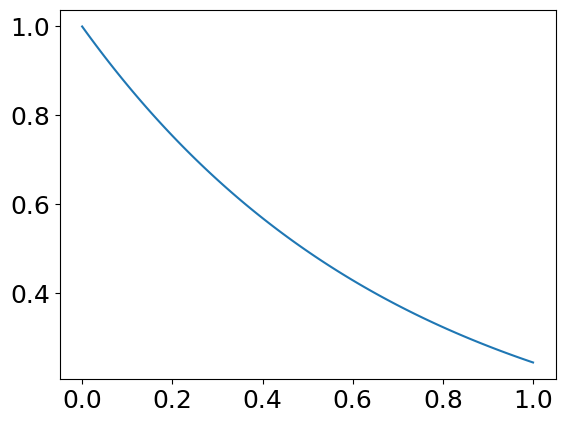

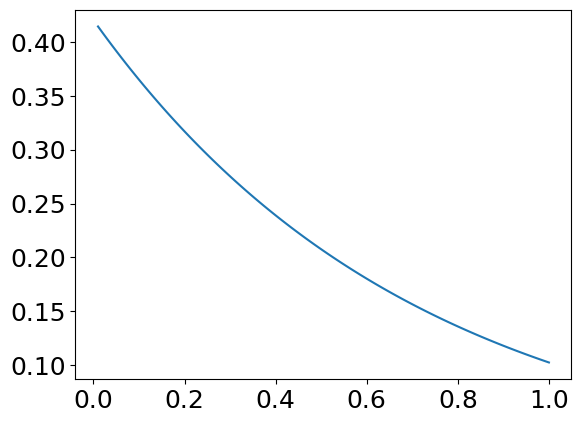

In [22]:
x0 = 1
tgrid = np.linspace(0,1,100)
xtraj = [x0]
ptraj = []

for i in range(1,100):
    xnew = xtraj[i-1] + 1/100*(-xtraj[i-1])*(1+(-2+np.sqrt(8))/2)
    xtraj.append(xnew)
    ptraj.append(2*(-2+np.sqrt(8))/4*xtraj[i-1])

plt.plot(tgrid,xtraj)
plt.show()
plt.plot(tgrid[1:],ptraj)
plt.show()


In [130]:
ptraj[0]

Array(0.41421356, dtype=float64, weak_type=True)

## Apply this Technique to a Differential Game Problem



In [496]:
import jax.numpy as np
from tfc import utfc

# Create the univariate TFC class
N = 100 # Number of points in the domain
m = 30 #  Degree of basis function expansion 
nC = 0 # Indicates which basis functions need to be removed from the expansion

myTfc = utfc(N,nC,m,x0=0,xf=3,basis="ELMSin")

t = myTfc.x # Collocation points from the TFC class

# Create the analytical solutions
fReal = np.vectorize(lambda t: np.exp(-3.0*t))
p1Real = np.vectorize(lambda t: -2*(-np.exp(-3.0*t)+1/np.exp(3.0)*np.exp(-2.0*t)))
p2Real = np.vectorize(lambda t: -2*(-4*np.exp(-3.0*t)-1/np.exp(3)*np.exp(-2*t)))
# Get the basis functions from the TFC class
H = myTfc.H

# Create the constrained expressions
g = lambda t,xi: np.dot(H(t),xi)
f =lambda t,xi_f: g(t,xi_f) +((3.0-t)/3.0)* (1.0 - g(np.zeros_like(t),xi_f)) 
p1 = lambda t,xi_p1: g(t,xi_p1) + t/3.0 * (0 - g(3*np.ones_like(t),xi_p1))
p2 = lambda t,xi_f,xi_p2: g(t,xi_p2) + t/3.0 * (10*f(3*np.ones_like(t),xi_f) - g(3*np.ones_like(t),xi_p2))


from tfc.utils import egrad, LS, TFCDict

# Create a TFCDict of the unknowns
xi0 = TFCDict({
    "xi_f": np.zeros(H(t).shape[1]),
    "xi_p1": np.zeros(H(t).shape[1]),
    "xi_p2": np.zeros(H(t).shape[1])
})

# Create the individual residuals
df = egrad(f)
dp1 = egrad(p1)
dp2 = egrad(p2)

Lf = lambda t,xi: df(t,xi["xi_f"]) - 2*f(t,xi["xi_f"]) + p1(t,xi["xi_p1"])/2 + p2(t,xi["xi_f"],xi["xi_p2"])/2 
Lp1 = lambda t,xi: dp1(t,xi["xi_p1"]) + 2*f(t,xi["xi_f"]) + 2*p1(t,xi["xi_p1"])
Lp2 = lambda t,xi: dp2(t,xi["xi_f"],xi["xi_p2"]) + 8*f(t,xi["xi_f"]) + 2*p2(t,xi["xi_f"],xi["xi_p2"])

# Combine the residuals into one function
L = lambda xi: np.hstack([Lf(t,xi), Lp1(t,xi), Lp2(t,xi)])

# Minimize the residual using least-squares
xi,time = LS(xi0,L,timer=True)


x0 is an integer. Converting to float to avoid errors down the line.
xf is an integer. Converting to float to avoid errors down the line.


Run time: 0.03125
Maximum error on f: 8.837376086218846e-07
Maximum error on p1: 2.242416629938404e-06
Maximum error on p2: 3.073152812591712e-06


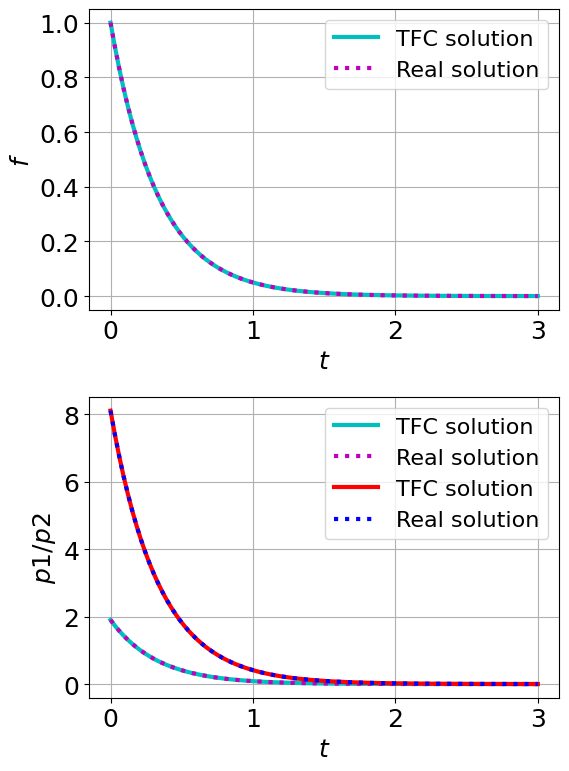

In [497]:
# Calculate the error on the test set
t_test = np.linspace(0.0, 3.0, 100)
errf = np.abs(f(t_test,xi["xi_f"]) - fReal(t_test))#/np.abs(fReal(t_test))
errp1 = p1(t_test,xi["xi_p1"]) - p1Real(t_test)
errp2 = np.abs(p2(t_test,xi["xi_f"],xi["xi_p2"]) - p2Real(t_test))#/np.abs(p2Real(t_test))

# Print out the results
print(f"Run time: {time}")
print(f"Maximum error on f: {np.max(np.abs(errf))}")
print(f"Maximum error on p1: {np.max(np.abs(errp1))}")
print(f"Maximum error on p2: {np.max(np.abs(errp2))}")

# Plot the results
from tfc.utils import MakePlot

# This line is added for Python notebooks but is not necessary in a regular Python script.
%matplotlib inline
import matplotlib
matplotlib

plt.close('all')
i = MakePlot([r"$t$",r"$t$"],[r"$f$",r"$p1/p2$"])
i.ax[0].plot(t_test,f(t_test,xi["xi_f"]),label="TFC solution",color="c",linewidth=3)
i.ax[0].plot(t_test,fReal(t_test),label="Real solution",color="m",linestyle=":",linewidth=3)
#plt.plot(t_test,y(t_test,xi["xi_y"]),label="TFC solution",color="c",linewidth=3)
#plt.plot(t_test,yReal(t_test),label="Real solution",color="m",linestyle=":",linewidth=3)
#plt.show()
i.ax[1].plot(t_test,p1(t_test,xi["xi_p1"]),label="TFC solution",color="c",linewidth=3)
i.ax[1].plot(t_test,p1Real(t_test),label="Real solution",color="m",linestyle=":",linewidth=3)
i.ax[1].plot(t_test,p2(t_test,xi["xi_f"],xi["xi_p2"]),label="TFC solution",color="r",linewidth=3)
i.ax[1].plot(t_test,p2Real(t_test),label="Real solution",color="b",linestyle=":",linewidth=3)
for ax in i.ax:
    ax.legend()
    ax.grid()
i.PartScreen(6,8)
i.fig.tight_layout(w_pad=None)
plt.show()

Slightly harder DG problem

\begin{equation}
\begin{split}
\dot{x}_1(t) &= x_2(t)\\
\dot{x}_2(t) &= x_1^2(t)+u_1(t)+u_2(t)\\
\end{split}
\end{equation}
with $x_1(0)=1, x_2(0)=1$ over time window $t\in [0,5]$.  The cost functionals are
\begin{equation}
\begin{split}
\min_{u_1}J_1(u_1,u_2) &= \frac{1}{2}(0.1x_1^2(T) + x_2^2(T))+\frac{1}{2}\int_0^T 0.1x_1^2(t) +x_2^2(t)+u_1^2(t)+u_2^2(t)dt\\
\min_{u_2}J_2(u_1,u_2) &= \frac{1}{2}(x_1^2(T)+0.1x_2^2(T))+\frac{1}{2}\int_0^T x_1^2(t) +0.1x_2^2(t)+u_1^2(t)+u_2^2(t)dt
\end{split}
\end{equation}
We formulate the following Hamiltonians
\begin{equation}
\begin{split}
H_1(t) &= \frac{1}{2}(0.1x_1^2(t) +x_2^2(t)+u_1^2(t)+u_2^2(t)) + p_{11}(x_2(t)) + p_{12}(x_1^2(t)+u_1(t)+u_2(t))\\
H_2(t) &= \frac{1}{2}(x_1^2(t) +0.1x_2^2(t)+u_1^2(t)+u_2^2(t)) + p_{21}(x_2(t)) + p_{22}(x_1^2(t)+u_1(t)+u_2(t))
\end{split}
\end{equation}

In [4]:
import jax.numpy as np
from tfc import utfc

# Create the univariate TFC class
N = 100 # Number of points in the domain
m = 30 #  Degree of basis function expansion 
nC = 1 # Indicates which basis functions need to be removed from the expansion

myTfc = utfc(N,nC,m,x0=0,xf=5,basis="CP")

t = myTfc.x # Collocation points from the TFC class

# Create the analytical solutions

# Get the basis functions from the TFC class
H = myTfc.H

# Create the constrained expressions
g = lambda t,xi: np.dot(H(t),xi)
f1 =lambda t,xi_f1: g(t,xi_f1) +((5.0-t)/5.0)* (1.0 - g(np.zeros_like(t),xi_f1))
f2 =lambda t,xi_f2: g(t,xi_f2) +((5.0-t)/5.0)* (1.0 - g(np.zeros_like(t),xi_f2))
p11 = lambda t,xi_f1,xi_p11: g(t,xi_p11) + t/5.0 * (0.1*f1(5*np.ones_like(t),xi_f1) - g(5*np.ones_like(t),xi_p11))
p12 = lambda t,xi_f2,xi_p12: g(t,xi_p12) + t/5.0 * (f2(5*np.ones_like(t),xi_f2) - g(5*np.ones_like(t),xi_p12))
p21 = lambda t,xi_f1,xi_p21: g(t,xi_p21) + t/5.0 * (f1(5*np.ones_like(t),xi_f1) - g(5*np.ones_like(t),xi_p21))
p22 = lambda t,xi_f2,xi_p22: g(t,xi_p22) + t/5.0 * (0.1*f2(5*np.ones_like(t),xi_f2) - g(5*np.ones_like(t),xi_p22))

from tfc.utils import BF, NLLS, MakePlot

# Create a TFCDict of the unknowns
xi0 = TFCDict({
    "xi_f1": np.zeros(H(t).shape[1]),
    "xi_f2": np.zeros(H(t).shape[1]),
    "xi_p11": np.zeros(H(t).shape[1]),
    "xi_p12": np.zeros(H(t).shape[1]),
    "xi_p21": np.zeros(H(t).shape[1]),
    "xi_p22": np.zeros(H(t).shape[1])
})

# Create the individual residuals
df1 = egrad(f1)
df2 = egrad(f2)
dp11 = egrad(p11)
dp12 = egrad(p12)
dp21 = egrad(p21)
dp22 = egrad(p22)

Lf1 = lambda t,xi: df1(t,xi["xi_f1"]) - f2(t,xi["xi_f2"])
Lf2 = lambda t,xi: df2(t,xi["xi_f2"]) - f1(t,xi["xi_f1"])**2 + p12(t,xi["xi_f2"],xi['xi_p12'])+ p22(t,xi["xi_f2"],xi['xi_p22'])
Lp11 = lambda t,xi: dp11(t,xi['xi_f1'],xi["xi_p11"]) + 0.1*f1(t,xi["xi_f1"]) + 2*p12(t,xi["xi_f2"],xi["xi_p12"])*f1(t,xi['xi_f1'])
Lp12 = lambda t,xi: dp12(t,xi["xi_f2"],xi["xi_p12"]) + f2(t,xi["xi_f2"]) + p11(t,xi["xi_f1"],xi["xi_p11"])
Lp21 = lambda t,xi: dp21(t,xi['xi_f1'],xi["xi_p21"]) + f1(t,xi["xi_f1"]) + 2*p22(t,xi["xi_f2"],xi["xi_p22"])*f1(t,xi['xi_f1'])
Lp22 = lambda t,xi: dp22(t,xi["xi_f2"],xi["xi_p22"]) + 0.1* f2(t,xi["xi_f2"]) + p21(t,xi["xi_f1"],xi["xi_p21"])

# Combine the residuals into one function
L = lambda xi: np.hstack([Lf1(t,xi),Lf2(t,xi), Lp11(t,xi), Lp12(t,xi),Lp21(t,xi), Lp22(t,xi)])

# Minimize the residual using least-squares
xi,time = LS(xi0,L,timer=True)


x0 is an integer. Converting to float to avoid errors down the line.
xf is an integer. Converting to float to avoid errors down the line.


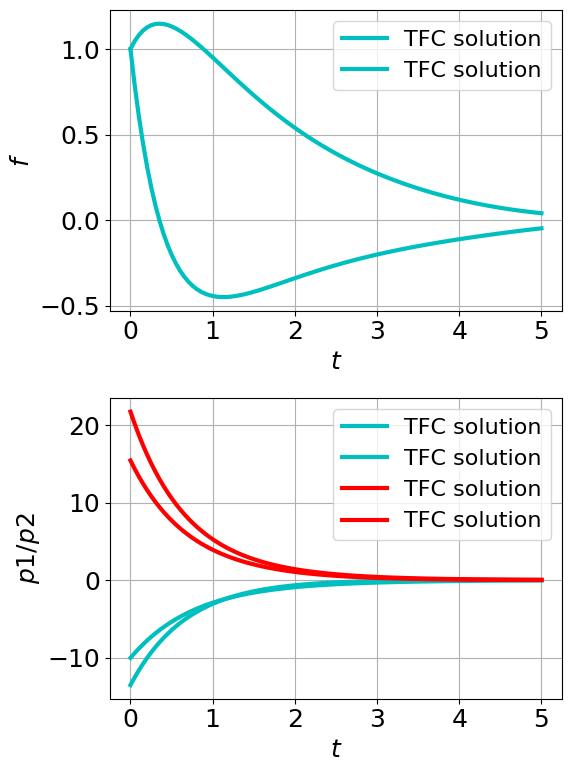

In [80]:
# Calculate the error on the test set
t_test = np.linspace(0.0, 5.0, 100)

# Plot the results
from tfc.utils import MakePlot

# This line is added for Python notebooks but is not necessary in a regular Python script.
%matplotlib inline
import matplotlib
matplotlib

plt.close('all')
i = MakePlot([r"$t$",r"$t$"],[r"$f$",r"$p1/p2$"])
i.ax[0].plot(t_test,f1(t_test,xi["xi_f1"]),label="TFC solution",color="c",linewidth=3)
i.ax[0].plot(t_test,f2(t_test,xi["xi_f2"]),label="TFC solution",color="c",linewidth=3)
#i.ax[0].plot(t_test,fReal(t_test),label="Real solution",color="m",linestyle=":",linewidth=3)
#plt.plot(t_test,y(t_test,xi["xi_y"]),label="TFC solution",color="c",linewidth=3)
#plt.plot(t_test,yReal(t_test),label="Real solution",color="m",linestyle=":",linewidth=3)
#plt.show()
i.ax[1].plot(t_test,p11(t_test,xi["xi_f1"],xi["xi_p11"]),label="TFC solution",color="c",linewidth=3)
i.ax[1].plot(t_test,p12(t_test,xi["xi_f2"],xi["xi_p12"]),label="TFC solution",color="c",linewidth=3)
#i.ax[1].plot(t_test,p1Real(t_test),label="Real solution",color="m",linestyle=":",linewidth=3)
i.ax[1].plot(t_test,p21(t_test,xi["xi_f1"],xi["xi_p21"]),label="TFC solution",color="r",linewidth=3)
i.ax[1].plot(t_test,p22(t_test,xi["xi_f2"],xi["xi_p22"]),label="TFC solution",color="r",linewidth=3)
#i.ax[1].plot(t_test,p2Real(t_test),label="Real solution",color="b",linestyle=":",linewidth=3)
for ax in i.ax:
    ax.legend()
    ax.grid()
i.PartScreen(6,8)
i.fig.tight_layout(w_pad=None)
plt.show()

## Homicidal Chauffeur Problem

This problem has 2 different forms of the dynamics:

In Cartesian Coordinates:

\begin{equation}
\begin{split}
\dot{x}_1 &= w_1\sin\theta\\
\dot{y}_1 &= w_1\cos \theta \\
\dot{x}_2 &= w_2\sin \psi\\
\dot{y}_2 &= w_2\cos \psi\\
\dot{\theta} &= \frac{w_1}{R}\phi
\end{split}
\end{equation}

In Reduced Polar Form:

let $x = x_1-x_2$, then

\begin{equation}
\begin{split}
\dot{x} &= w_1\sin \theta -w_2 \sin \psi\\
\dot{y}_1 &= w_1 \cos \phi \\
\dot{y}_2 &= w_2 \cos \psi
\end{split}
\end{equation}

In fully reduced form with relative x and y coordinates:

\begin{equation}
\begin{split}
\dot{x} &= -\frac{w_1}{R}y \phi +w_2\sin\psi\\
\dot{y} &= \frac{w_1}{R}x\phi -w_1 +w_2\cos \psi,
\end{split}
\end{equation}
where $|\phi|\leq 1$ and $\psi \in[0,2\pi)$.

We can further simplify and normalize this problem, such that the equations of motion become
\begin{equation}
\begin{split}
\dot{x} &= -y\phi + \gamma \sin \psi\\
\dot{y} &= x\phi -1 +\gamma \cos \psi
\end{split}
\end{equation}
where $|\phi|\leq 1$ and $\psi \in [0,2\pi)$ measured relative to the pursuer's vertical axis.

The solution is constructed over several different stages via characteristic curves that converge into singular surfaces.  The solution technique is to use retrograde integration and to start from one surface propagate the characteristic curves until another characteristic surface is reached or until the max retrograde time limit is reached.


We have the Hamiltonian
\begin{equation}
\begin{split}
\min_{\phi}\max_{\psi} H(\phi,\psi) &=\min_{\phi}\max_{\psi}\left( 1 + p_x(-y\phi +\gamma \sin \psi) + p_y(x\phi -1 + \gamma \cos \psi) \right)\\
& = \min_{\phi}\max_{\psi}\left[1 + \phi(xp_y-yp_x)-p_y+\gamma(p_x\sin\psi+p_y\cos\psi)\right]\\
\end{split}
\end{equation}
This furnishes 2 separate Hamiltonians
\begin{equation}
\begin{split}
\min_{\phi}\max_{\psi}H& = \min_{\phi}\max_{\psi}\left[1 + \phi(xp_y-yp_x)-p_y+\gamma(p_x\sin\psi+p_y\cos\psi)\right]\\
&= \min_{\phi}(\phi(xp_y-yp_x)) + \max_{\psi}(\gamma(p_x\sin\psi+p_y\cos\psi))+1-p_y\\
\min_{\phi}H_1(\phi) &= \min_{\phi}(\phi(xp_y-yp_x))\\
\max_{\psi}H_2(\psi) &= \max_{\psi}(\gamma(p_x\sin\psi+p_y\cos\psi))\\
\Rightarrow \min_{\psi} (-H_2(\psi)) &= \min_{\psi}(-(p_x\sin\psi+p_y\cos\psi))\\
\end{split}
\end{equation}
A priori we know that

\begin{equation}
\begin{split}
\phi^* &= Sign(-xp_y+yp_x)\\
\sin^*(\psi) &= \frac{p_x}{\sqrt{p_x^2+p_y^2}}\\
\cos^*(\psi) &= \frac{p_y}{\sqrt{p_x^2+p_y^2}}\\
\end{split}
\end{equation}

In [ ]:
from tfc import utfc
from tfc.utils import TFCDictRobust, egrad, NllsClass, MakePlot

import numpy as onp
import jax.numpy as np
from jax import vmap, jacfwd, jit, lax

import tqdm
import pickle

from scipy.integrate import simpson
from time import process_time as timer

## TEST PARAMETERS: ***************************************************
tol = np.finfo(float).eps
maxIter = 50
W = False

if W == False:
    Gam = 0.
else:
    Gam = 100. # parameter associated with terminal cost


## CONSTANTS: *********************************************************
# Number of points to use
N = 100

# Number of basis functions to use
ms = 30 # for function r 
mc = 1 # for time b

# Number of constraints
nCx = 4 # mumber of constraints in the constrained expression 
nCy = 0 

## GET CHEBYSHEV VALUES **********************************************
stfc = utfc(N,nCx,ms,basis='CP',x0 = -1, xf = 1.) # state variable
ctfc = utfc(N,nCy,mc,basis='CP',x0 = -1, xf = 1.) # control variable

Hs  = stfc.H # actual basis of functions with removed constraints and added end points
pHs  = stfc.dH # takes derivative of basis functions used


Hs0 = Hs(stfc.z[0:1]) # starting point output (-1, Hs(-1))
Hsf = Hs(stfc.z[-1:]) # ending point output (1, Hs(1))


pHs0 = pHs(stfc.z[0:1]) # starting derivative at z = -1
pHsf = pHs(stfc.z[-1:]) # ending derivative at z = 1

Hc  = ctfc.H # for control function



x0 is an integer. Converting to float to avoid errors down the line.
x0 is an integer. Converting to float to avoid errors down the line.
[[ 1.         -1.        ]
 [ 1.         -0.99949654]
 [ 1.         -0.99798668]
 [ 1.         -0.99547192]
 [ 1.         -0.99195481]
 [ 1.         -0.98743889]
 [ 1.         -0.9819287 ]
 [ 1.         -0.97542979]
 [ 1.         -0.9679487 ]
 [ 1.         -0.95949297]
 [ 1.         -0.95007112]
 [ 1.         -0.93969262]
 [ 1.         -0.92836793]
 [ 1.         -0.91610846]
 [ 1.         -0.90292654]
 [ 1.         -0.88883545]
 [ 1.         -0.87384938]
 [ 1.         -0.85798341]
 [ 1.         -0.84125353]
 [ 1.         -0.82367658]
 [ 1.         -0.80527026]
 [ 1.         -0.78605309]
 [ 1.         -0.76604444]
 [ 1.         -0.74526445]
 [ 1.         -0.72373404]
 [ 1.         -0.70147489]
 [ 1.         -0.67850941]
 [ 1.         -0.65486073]
 [ 1.         -0.63055267]
 [ 1.         -0.60560969]
 [ 1.         -0.58005691]
 [ 1.         -0.55392006

In [25]:

## DEFINE THE ASSUMED SOLUTION **************************************
z = stfc.z # z scale from -1 to 1
z0 = z[0]
zf = z[-1]



## DEFINE SWITCHING FUNCTIONS ***************************************
phi1 = lambda a: np.expand_dims(\
                 1./(zf-z0)**3 * (-zf**2*(3.*z0-zf) + 6.*z0*zf*a - 3.*(z0+zf)*a**2 + 2.*a**3),1)
phi2 = lambda a: np.expand_dims(\
                1./(zf-z0)**3 * (-z0**2*(z0-3.*zf) - 6.*z0*zf*a + 3.*(z0+zf)*a**2 - 2.*a**3),1)
phi3 = lambda a: np.expand_dims(\
                1./(zf-z0)**2 * (-z0*zf**2 + zf*(2.*z0+zf)*a - (z0+2.*zf)*a**2 + a**3),1)
phi4 = lambda a: np.expand_dims(\
                1./(zf-z0)**2 * (-z0**2*zf + z0*(z0+2.*zf)*a - (2.*z0+zf)*a**2 + a**3),1)


## DEFINE CONSTRAINED EXPRESSION *************************************
r = lambda z, xi, IC: np.dot(Hs(z),xi['xis']) \
                    + phi1(z)*(IC['R0']             - np.dot(Hs0, xi['xis'])) \
                    + phi2(z)*(                     - np.dot(Hsf, xi['xis'])) \
                    + phi3(z)*(IC['V0']/xi['b']**2  - np.dot(pHs0,xi['xis'])) \
                    + phi4(z)*(                     - np.dot(pHsf,xi['xis']))

v = egrad(r)
a = egrad(v)


lam = lambda z, xi: np.dot(Hc(z),xi['xic']) # constrained expression for control without constraints


## FORM LOSS AND JACOBIAN ***********************************************************************************
Ls  = lambda xi,IC: xi['b']**4 * a(z,xi,IC) - IC['ag'] + lam(z,xi) # loss for any time
Htf = lambda xi,IC: np.dot(lam(z,xi)[-1,:],(-1./2.*lam(z,xi)[-1,:] + IC['ag'])) + IC['Gam'] # Hamiltonian at final time 
L = jit(lambda xi,IC: np.hstack([Ls(xi,IC).flatten(), Htf(xi,IC)] )) 

## INITIALIZE VARIABLES *************************************************************************************
xis   = onp.zeros((Hs(z).shape[1],3)) # zeros for coefficients of state variable
xic   = onp.zeros((Hc(z).shape[1],3)) # zeros for coefficients of control variable

if W == False:
    b = np.sqrt(2)*onp.ones(1) # initial guess for final time b
else:
    b = np.sqrt(10)*onp.ones(1)


xi = TFCDictRobust({'xis':xis,\
                    'xic':xic,\
                    'b':b})

IC = {'R0': np.zeros((3,)), 'V0': np.zeros((3,)), 'ag': np.zeros((3,)), 'Gam': np.zeros((1,))}

## NONLINEAR LEAST-SQUARES CLASS *****************************************************************************
nlls = NllsClass(xi,L,IC,tol=tol,maxIter=maxIter,timer=True)

R0 = np.array([500000., 100000., 50000.])
V0 = np.array([-3000., 0., 0.])

## scale initial conditons
pscale = np.max(np.abs(R0))
tscale = pscale/np.max(np.abs(V0))

IC['R0']    = R0 / pscale
IC['V0']    = V0 * tscale/pscale
IC['ag']    = np.array([0., 0., -5.314961]) * tscale**2/pscale
IC['Gam']   = Gam * tscale**4/pscale**2

xi,it,time = nlls.run(xi,IC)

## CONSTRUCT SOLUTION  **********************************************
t = (z-z[0])/xi['b']**2 * tscale
IC['Gam']= IC['Gam'] * pscale**2/tscale**4

R = r(z,xi,IC) * pscale
V = v(z,xi,IC) * pscale/tscale

LamV = lam(z,xi) * pscale/tscale**2
LamR = -xi['b']**2 * egrad(lam)(z,xi) * pscale/tscale**3

Ac = - LamV

Ham = onp.zeros(len(t))
int = onp.zeros(len(t))
a_mag = onp.zeros(len(t))
for i in range(0,len(t)):
    int[i] = np.dot(Ac[i,:],Ac[i,:])
    Ham[i] = 0.5*int[i] + np.dot(LamR[i,:],V[i,:]) + np.dot(LamV[i,:],IC['ag'] + Ac[i,:])
    a_mag[i] = np.linalg.norm(Ac[i,:])

cost = IC['Gam']* t[-1] +  0.5 * simpson(int,x=t)

##: print final answers to screen
print('\nFinal time [s]:\t' + str(t[-1]))
print('Cost:\t\t' + str(cost))
print('Comp time [ms]:\t' + str(time*1000))
print('Iterations:\t' + str(it))
print('Loss:\t\t' +  str(np.max(L(xi,IC))))


Final time [s]:	406.03839585944576
Cost:		19004.12384915085
Comp time [ms]:	171.875
Iterations:	15
Loss:		2.220446049250313e-16


In [449]:
from tfc import utfc
from tfc.utils import TFCDictRobust, egrad, NllsClass, MakePlot

import numpy as onp
import jax.numpy as np
from jax import vmap, jacfwd, jit, lax

import tqdm
import pickle

from scipy.integrate import simpson
from time import process_time as timer

## TEST PARAMETERS: ***************************************************
tol = np.finfo(float).eps
maxIter = 100
W = False

#if W == False:
#    Gam = 0.
#else:
#    Gam = 100.

Gam = 1./2.

## CONSTANTS: *********************************************************
# Number of points to use
N = 100

# Number of basis functions to use
ms = 50

# Number of constraints
nCx = 1

## GET CHEBYSHEV VALUES **********************************************
stfc = utfc(N,nCx,ms,basis='CP',x0 = -1, xf = 1.)

Hs  = stfc.H # basis functions for state variable
#dHs  = stfc.dH # basis functions for the derivative

Hs0 = Hs(stfc.z[0:1])
Hsf = Hs(stfc.z[-1:])

#dHs0 = dHs(stfc.z[0:1])
#dHsf = dHs(stfc.z[-1:])

## DEFINE THE ASSUMED SOLUTION **************************************
z = stfc.z
z0 = z[0]
zf = z[-1]


phi1 = lambda a: np.expand_dims((zf-a)/(zf-z0),1)
phi2 = lambda a: np.expand_dims((a-z0)/(zf-z0),1)

## DEFINE CONSTRAINED EXPRESSION *************************************

x  = lambda z, xi, IC: np.dot(Hs(z),xi['xix']) +phi1(z)* ( IC['X0'] - np.dot(Hs0,xi['xix'])) 
y  = lambda z, xi, IC: np.dot(Hs(z),xi['xiy']) +phi1(z)* ( IC['Y0'] - np.dot(Hs0,xi['xiy'])) 
#px = lambda z, xi, IC: np.dot(Hs(z),xi['xipx']) + phi2(z) * (IC['lamf'] - np.dot(Hsf,xi['xipx']))
#py = lambda z, xi, IC: np.dot(Hs(z),xi['xipy']) + phi2(z) * (IC['lamf'] - np.dot(Hsf,xi['xipy']))
px = lambda z, xi, IC: np.dot(Hs(z),xi['xipx']) + phi2(z) * (-0*np.dot(Hsf,xi['xix']) - np.dot(Hsf,xi['xipx']))
py = lambda z, xi, IC: np.dot(Hs(z),xi['xipy']) + phi2(z) * (-20*np.dot(Hsf,xi['xiy']) - np.dot(Hsf,xi['xipy']))

dx = egrad(x)
dy = egrad(y)
dpx = egrad(px)
dpy = egrad(py)

Indtanh = lambda z,xi,IC, d: np.tanh((x(z,xi,IC)*py(z,xi, IC)-y(z,xi,IC)*px(z,xi, IC))/d)

#ro = 1

costmag = lambda z,xi, IC: np.sqrt(px(z,xi, IC)**2 + py(z,xi, IC)**2)

d= 1e-20

## FORM LOSS AND JACOBIAN ***********************************************************************************
#Lx  = lambda xi,IC: xi['b']**2*dx(z,xi,IC) - Indtanh(z,xi,IC,d)*y(z,xi,IC) - IC['Gam']*px(z,xi, IC)/costmag(z,xi, IC)
#Ly = lambda xi,IC: xi['b']**2*dy(z,xi,IC) - Indtanh(z,xi,IC, d)*x(z,xi,IC) + 1 - IC['Gam']*py(z,xi, IC)/costmag(z,xi, IC)
#Lpx = lambda xi,IC: xi['b']**2*dpx(z,xi, IC) + Indtanh(z,xi,IC, d)*py(z,xi, IC)
#Lpy = lambda xi,IC: xi['b']**2*dpy(z,xi, IC) - Indtanh(z,xi,IC, d)*px(z,xi, IC)
#Htf = lambda xi,IC: -1+px(z,xi, IC)[-1,:]*(-1*Indtanh(z,xi,IC, d)[-1,:]*y(z,xi,IC)[-1,:]+IC['Gam']*px(z,xi, IC)[-1,:]/costmag(z,xi, IC)[-1,:])+py(z,xi, IC)[-1,:]*(Indtanh(z,xi,IC,d)[-1,:]*x(z,xi,IC)[-1,:]-1+IC['Gam']*py(z,xi, IC)[-1,:]/costmag(z,xi, IC)[-1,:])
#Ttf = lambda xi, IC: x(z, xi,IC)[-1,:]**2 + y(z,xi, IC)[-1,:]**2 - IC['l']**2

Lx  = lambda xi,IC: xi['b']**2*dx(z,xi,IC) - y(z,xi,IC) - IC['Gam']*px(z,xi, IC)/costmag(z,xi, IC)
Ly = lambda xi,IC: xi['b']**2*dy(z,xi,IC) - x(z,xi,IC) + 1 - IC['Gam']*py(z,xi, IC)/costmag(z,xi, IC)
Lpx = lambda xi,IC: xi['b']**2*dpx(z,xi, IC) + py(z,xi, IC)
Lpy = lambda xi,IC: xi['b']**2*dpy(z,xi, IC) - px(z,xi, IC)
Htf = lambda xi,IC: -1+px(z,xi, IC)[-1,:]*(-1*y(z,xi,IC)[-1,:]+IC['Gam']*px(z,xi, IC)[-1,:]/costmag(z,xi, IC)[-1,:])+py(z,xi, IC)[-1,:]*(x(z,xi,IC)[-1,:]-1+IC['Gam']*py(z,xi, IC)[-1,:]/costmag(z,xi, IC)[-1,:])
Ttf = lambda xi, IC: x(z, xi,IC)[-1,:]**2 + y(z,xi, IC)[-1,:]**2 - IC['l']**2

#xybarrier = lambda xi, IC: -1*np.log(x(z, xi,IC)) + -1*np.log(y(z, xi,IC))
L = jit(lambda xi,IC: np.hstack([Lx(xi,IC).flatten(),Ly(xi,IC).flatten(),Lpx(xi, IC).flatten(),Lpy(xi, IC).flatten(), Htf(xi,IC), Ttf(xi,IC)]))#, xybarrier(xi, IC).flatten()]))

## INITIALIZE VARIABLES *************************************************************************************

onp.random.seed(32) #32, 42
xix   = onp.random.random((Hs(z).shape[1],1))
xiy   = onp.random.random((Hs(z).shape[1],1))
xipx   = onp.random.random((Hs(z).shape[1],1))
xipy   = onp.random.random((Hs(z).shape[1],1))
b =  2*onp.ones(1)


xi = TFCDictRobust({'xix':xix,\
                    'xiy':xiy,\
                    'xipx':xipx,\
                    'xipy':xipy,\
                    'b':b})

IC = {'X0': np.zeros((1,)), 'Y0':np.zeros((1,)),'Gam':np.zeros((1,)),'lamf':np.zeros((1,)),'l':np.zeros((1,))}

x0 is an integer. Converting to float to avoid errors down the line.


In [450]:

## NONLINEAR LEAST-SQUARES CLASS *****************************************************************************
nlls = NllsClass(xi,L,IC,tol=tol,maxIter=maxIter,timer=True)

X0 = np.array([0.459698])
Y0 = np.array([0.841471])

## scale initial conditons
pscale = 1 # np.max(np.abs(R0))
tscale = 1 # pscale/np.max(np.abs(V0))

IC['X0'] = X0
IC['Y0'] = Y0
IC['Gam'] = np.array([0.5])
IC['lamf'] = np.array([0.0])
IC['l'] = np.array([0.5])

#IC['R0']    = R0 / pscale
#IC['V0']    = V0 * tscale/pscale
#IC['ag']    = np.array([0., 0., -5.314961]) * tscale**2/pscale
#IC['Gam']   = Gam * tscale**4/pscale**2
xi,it,time = nlls.run(xi, IC)

state1 = x(z,xi,IC)
state2 = y(z,xi,IC)
costate1 = px(z,xi,IC)
costate2 = py(z,xi,IC)

## CONSTRUCT SOLUTION  **********************************************
t = (z-z[0])/xi['b']**2 * tscale
#IC['Gam']= IC['Gam'] * pscale**2/tscale**4

#R = r(z,xi,IC) * pscale
#V = v(z,xi,IC) * pscale/tscale

#LamV = lam(z,xi) * pscale/tscale**2
#LamR = -xi['b']**2 * egrad(lam)(z,xi) * pscale/tscale**3

#Ac = - LamV


In [394]:
#print(L(xi,IC))
print(x(z[0:5],xi,IC))
#print(y[0:5])
circpara = np.linspace(0,np.arccos(1/2),100)
xcoorcirc = np.cos(circpara)/2
ycoorcirc = np.sin(circpara)/2


[[0.459698  ]
 [0.45764567]
 [0.45163073]
 [0.44166854]
 [0.42762055]]


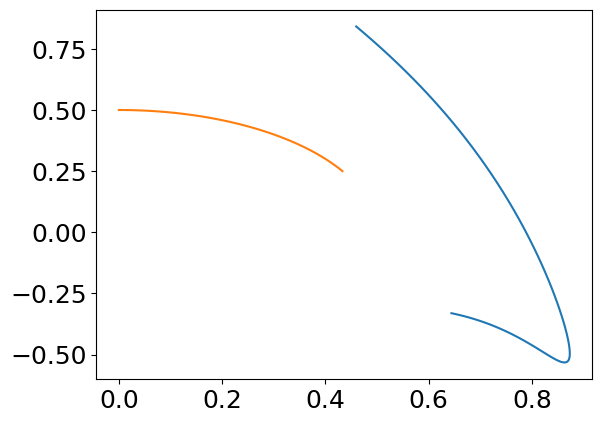

In [451]:
#plt.plot(t,costate2)
plt.plot(state1[0:100],state2[0:100])
plt.plot(ycoorcirc,xcoorcirc)
plt.show()


In [452]:


cost = t[-1]

##: print final answers to screen
print('\nFinal time [s]:\t' + str(t[-1]))
print('Cost:\t\t' + str(cost))
print('Comp time [ms]:\t' + str(time*1000))
print('Iterations:\t' + str(it))
print('Loss:\t\t' +  str(np.max(L(xi,IC))))


Final time [s]:	3.8257523982031914
Cost:		3.8257523982031914
Comp time [ms]:	4468.75
Iterations:	100
Loss:		0.2744308278110402


In [ ]:
import jax.numpy as np
from tfc import utfc
from tfc.utils import BF, NLLS, MakePlot

# initial condition
f10 = 0.38
f20 = 0.75
gamma = 0.5 # vE/vP

# Create the univariate TFC class
N = 100 # Number of points in the domain
m = 30 #  Degree of basis function expansion 
nC = 1 # Indicates which basis functions need to be removed from the expansion

myTfc = utfc(N,nC,m,x0=0,xf=1, basis="CP")

t = myTfc.x # Collocation points from the TFC class

# Create the analytical solutions
#fReal = np.vectorize(lambda t: np.exp(-3.0*t))
#p1Real = np.vectorize(lambda t: -2*(-np.exp(-3.0*t)+1/np.exp(3.0)*np.exp(-2.0*t)))
#p2Real = np.vectorize(lambda t: -2*(-4*np.exp(-3.0*t)-1/np.exp(3)*np.exp(-2*t)))
# Get the basis functions from the TFC class
H = myTfc.H

# Create the constrained expressions
g = lambda t,xi: np.dot(H(t),xi)
f1 =lambda t,tf,xi_f1: g(t,xi_f1) +((tf-t)/tf)* (f10 - g(np.zeros_like(t),xi_f1)) 
f2 =lambda t,tf,xi_f2: g(t,xi_f2) +((tf-t)/tf)* (f20 - g(np.zeros_like(t),xi_f2))
p1 = lambda t,tf,xi_p1: g(t,xi_p1) + t/tf * (0 - g(tf*np.ones_like(t),xi_p1))
p2 = lambda t,tf,xi_p2: g(t,xi_p2) + t/tf * (0 - g(tf*np.ones_like(t),xi_p2))


from tfc.utils import egrad, LS, TFCDict

# Create a TFCDict of the unknowns
xi0 = TFCDict({
    "xi_f1": np.zeros(H(t).shape[1]),
    "xi_f2": np.zeros(H(t).shape[1]),
    "xi_p1": np.zeros(H(t).shape[1]),
    "xi_p2": np.zeros(H(t).shape[1]),
    "tf": np.ones(1)
})

# Create the individual residuals
df1 = egrad(f1)
df2 = egrad(f2)
dp1 = egrad(p1)
dp2 = egrad(p2)

Indtanh = lambda t,xi0: np.tanh((-f1(t,xi0['tf'],xi0['xi_f1'])*p2(t,xi0['tf'],xi0['xi_p2'])\
    +f2(t,xi0['tf'],xi0['xi_f2'])*p1(t,xi0['tf'],xi0['xi_p1']))/1)

#ro = 1

costmag = lambda t,xi0: np.sqrt(p1(t,xi0['tf'],xi0['xi_p1'])**2 + p2(t,xi0['tf'],xi0['xi_p2'])**2)

Lf1 = lambda t,xi0: df1(t,xi0['tf'],xi0["xi_f1"]) + Indtanh(t,xi0)*f2(t,xi0['tf'],xi0["xi_f2"])\
    -gamma*p1(t,xi0['tf'],xi0['xi_p1'])/costmag(t,xi0)

Lf2 = lambda t,xi0: df2(t,xi0['tf'],xi0["xi_f2"]) - Indtanh(t,xi0)*f1(t,xi0['tf'],xi0["xi_f1"])+1\
    -gamma*p2(t,xi0['tf'],xi0['xi_p2'])/costmag(t,xi0)

Lp1 = lambda t,xi0: dp1(t,xi0['tf'],xi0["xi_p1"]) + p2(t,xi0['tf'],xi0["xi_p2"])*Indtanh(t,xi0)
Lp2 = lambda t,xi0: dp2(t,xi0['tf'],xi0["xi_p2"]) + p1(t,xi0['tf'],xi0["xi_p1"])*Indtanh(t,xi0)

LHf = lambda t,xi0: 

# Combine the residuals into one function
L = lambda xi: np.hstack([Lf1(t,xi),Lf2(t,xi), Lp1(t,xi), Lp2(t,xi)])

# Minimize the residual using least-squares
xi,it,time = NLLS(xi0,L,timer=True)


x0 is an integer. Converting to float to avoid errors down the line.
xf is an integer. Converting to float to avoid errors down the line.


TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function cond at c:\Users\NonAdmin RP\.conda\envs\JupyterNBTest\Lib\site-packages\tfc\utils\TFCUtils.py:1188 for while_cond. This value became a tracer due to JAX operations on these lines:

  operation a[35m:f64[100][39m = broadcast_in_dim[
  broadcast_dimensions=()
  shape=(100,)
  sharding=None
] 0.0:f64[]
    from line C:\Users\NonAdmin RP\AppData\Local\Temp\ipykernel_6248\3266352933.py:28:57 (<lambda>)

  operation a[35m:f64[100][39m = sub 0.38:f64[] b
    from line C:\Users\NonAdmin RP\AppData\Local\Temp\ipykernel_6248\3266352933.py:28:49 (<lambda>)

  operation a[35m:f64[100][39m = broadcast_in_dim[
  broadcast_dimensions=()
  shape=(100,)
  sharding=None
] 0.0:f64[]
    from line C:\Users\NonAdmin RP\AppData\Local\Temp\ipykernel_6248\3266352933.py:28:57 (<lambda>)

  operation a[35m:f64[100][39m = sub 0.38:f64[] b
    from line C:\Users\NonAdmin RP\AppData\Local\Temp\ipykernel_6248\3266352933.py:28:49 (<lambda>)

  operation a[35m:f64[100][39m = broadcast_in_dim[
  broadcast_dimensions=()
  shape=(100,)
  sharding=None
] 1.0:f64[]
    from line C:\Users\NonAdmin RP\AppData\Local\Temp\ipykernel_6248\3266352933.py:31:54 (<lambda>)

(Additional originating lines are not shown.)
See https://docs.jax.dev/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [89]:
np.ones(2)

Array([1., 1.], dtype=float64)